In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [2]:
orders = pd.read_csv("olist_orders_dataset.csv")

In [3]:
orders.info()
print()
print("Unique Order Ids : {}".format(orders.order_id.nunique()))
print("Unique Customer Ids: {}".format(orders.customer_id.nunique()))

# each row of the dataset has uniqueness of order_id and customer_id
# each order has a status, purchase time & estimated delivery date

#ACTION: convert all timestamp columns to datetime type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB

Unique Order Ids : 99441
Unique Customer Ids: 99441


In [4]:
# Convert all date and time coluums to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Since we are only dealing with order delivery performance, we can remove the customer_id column
orders.drop('customer_id', axis=1, inplace=True)
# We can rely on natural dataframe index, so we can remove order_id column
orders.drop('order_id', axis=1, inplace=True)

In [6]:
purchase_na = orders.order_purchase_timestamp.isna()
approved_na = orders.order_approved_at.isna()
carrier_na = orders.order_delivered_carrier_date.isna()
customer_na = orders.order_delivered_customer_date.isna()

print("Total Orders: {}".format(orders.shape[0]))
print("Total Purchase: {}".format(orders[~(purchase_na)].shape[0]))
print("purchased, not approved: {}".format(orders[~(purchase_na) & (approved_na)].shape[0]))
print("purchased, approved: {}".format(orders[~(purchase_na) & ~(approved_na)].shape[0]))
print("purchased, approved, not delivered to carrier: {}".format(orders[~(purchase_na) & ~(approved_na) & (carrier_na)].shape[0]))
print("purchased, approved, delivered to carrier: {}".format(orders[~(purchase_na) & ~(approved_na) & ~(carrier_na)].shape[0]))
print("purchased, approved, delivered to carrier, not delivered to customer: {}".format(orders[~(purchase_na) & ~(approved_na) & ~(carrier_na) & (customer_na)].shape[0]))
print("purchased, approved, delivered to carrier, delivereed to customer: {}".format(orders[~(purchase_na) & ~(approved_na) & ~(carrier_na) & ~(customer_na)].shape[0]))

#Action: select orders which were purchased, approveed, delivered to carrier, delivered to customer

Total Orders: 99441
Total Purchase: 99441
purchased, not approved: 160
purchased, approved: 99281
purchased, approved, not delivered to carrier: 1637
purchased, approved, delivered to carrier: 97644
purchased, approved, delivered to carrier, not delivered to customer: 1183
purchased, approved, delivered to carrier, delivereed to customer: 96461


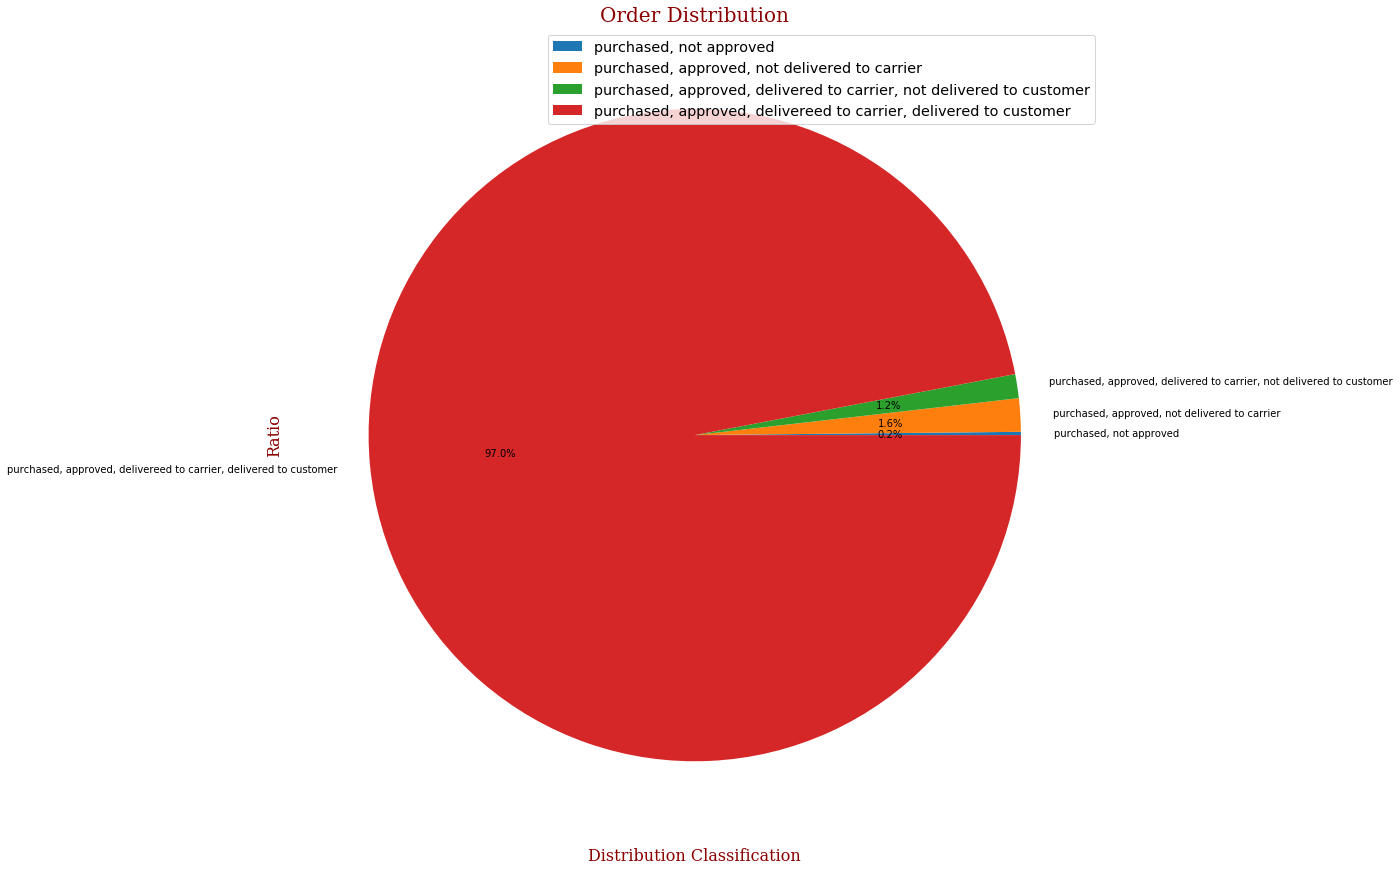

In [7]:
orders_len = len(orders)
dist = pd.DataFrame({'Ratio' :[orders[~(purchase_na) & (approved_na)].shape[0]/orders_len, orders[~(purchase_na) & ~(approved_na) & (carrier_na)].shape[0]/orders_len, orders[~(purchase_na) & ~(approved_na) & ~(carrier_na) & (customer_na)].shape[0]/orders_len, orders[~(purchase_na) & ~(approved_na) & ~(carrier_na) & ~(customer_na)].shape[0]/orders_len]}, index = ['purchased, not approved','purchased, approved, not delivered to carrier', 'purchased, approved, delivered to carrier, not delivered to customer', 'purchased, approved, delivereed to carrier, delivered to customer'])

dist.plot.pie(y='Ratio', autopct='%1.1f%%')
plt.title('Order Distribution', size=20, fontdict=font)
plt.xlabel('Distribution Classification', fontdict=font)
plt.ylabel('Ratio', fontdict=font)
plt.legend(loc='upper right', fontsize='x-large')
plt.gcf().set_size_inches(15, 15)
# visualize distribution
#INSIGHT: 97% of purchases were delivered to customer, less than 3% had issues at multiple levels; approval, delivery to carrier, delivery to customer

### Applying actions on orders table

In [8]:
# Select orders which were purchased, approved, delivered to carrier, delivered to customer
od = orders[~(purchase_na) & ~(approved_na) & ~(carrier_na) & ~(customer_na)].copy()

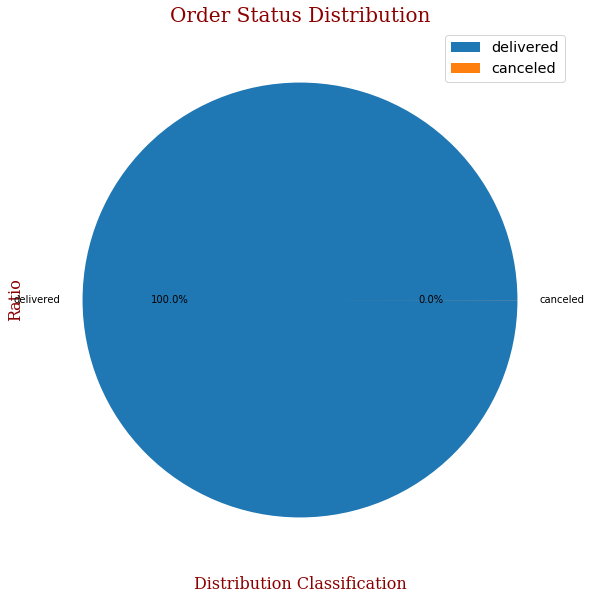

In [9]:
od.order_status.value_counts().plot.pie(legend=True, autopct='%1.1f%%')
plt.title('Order Status Distribution', size=20, fontdict=font)
plt.xlabel('Distribution Classification', fontdict=font)
plt.ylabel('Ratio', fontdict=font)
plt.legend(loc='upper right', fontsize='x-large')
plt.gcf().set_size_inches(10, 10)
# almost 100% of orders are delivered, let's get rid fo canceled items
#INSIGHT: there were a few orders which are in canceled state even after delivery to the customer

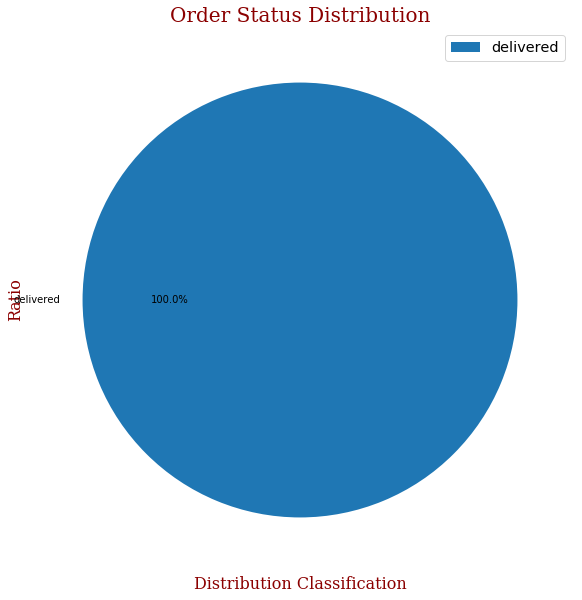

In [10]:
# od contains all delivered orders, so order_status must all be delivered, let's check
od.drop(index=od[od.order_status=='canceled'].index, inplace=True)
od.order_status.value_counts().plot.pie(legend=True, autopct='%1.1f%%')
plt.title('Order Status Distribution', size=20, fontdict=font)
plt.xlabel('Distribution Classification', fontdict=font)
plt.ylabel('Ratio', fontdict=font)
plt.legend(loc='upper right', fontsize='x-large')
plt.gcf().set_size_inches(10, 10)

In [11]:
# Since all order_status are "delivered", we can drop the column
od.drop('order_status', axis=1, inplace=True)

In [12]:
od.reset_index(inplace=True)
od.drop('index', axis=1, inplace=True)
od.tail()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
96450,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
96451,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
96452,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
96453,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15
96454,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03


### Derived Columns
* Difference between delivery levels
* Every datetime column can be split into year, month, date, hour columns

In [13]:
# Difference between delivery levels
ods_purchased_at = od['order_purchase_timestamp']
ods_approved_at = od['order_approved_at']
ods_deli_carrier_at = od['order_delivered_carrier_date']
ods_deli_customer_at = od['order_delivered_customer_date']
ods_est_deli_at = od['order_estimated_delivery_date']

od['order_approval_hours'] = (ods_approved_at - ods_purchased_at).apply(lambda x: x.seconds/3600)
od['seller_to_carrier_hours'] = (ods_deli_carrier_at - ods_approved_at).apply(lambda x: x.seconds/3600)
od['carrier_to_customer_hours'] = (ods_deli_customer_at - ods_deli_carrier_at).apply(lambda x: x.seconds/3600)
od['early_delivery_hours'] = (ods_est_deli_at - ods_deli_customer_at).apply(lambda x: x.seconds/3600)

od.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approval_hours,seller_to_carrier_hours,carrier_to_customer_hours,early_delivery_hours
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0.178333,8.795833,1.503611,2.579722
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,6.713889,11.109167,0.945833,8.537500
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0.276111,4.910278,4.274722,5.891944
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,0.298056,17.900000,10.811944,23.521667
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.030556,21.434722,22.507778,5.716111


In [14]:
pandas_profiling.ProfileReport(od).to_file('od_before.html')

## Observations after first profiling
* Usually, the orders are approved within 2.5 hours of purchase
* Seller to Carrier hours has a nearly quadratic relationship wiith its frequency. The frequency first decreases with increase in time taken, reaches a minima near 10-15 hours and then frequency increases with increase in time taken.
* Carrier to Customer has a quadratic relationship with its frequency.
* Usually the time taken by the seller is more than the carrier to move the order ahead.
* Usually the item reaches customer 5-7 hours earlier than the promised estimated time of delivery
* The bottlenecks of delivery from purchase to customer handover are at seller and carrier.

* No Missing/invalid data

### Time series analysis

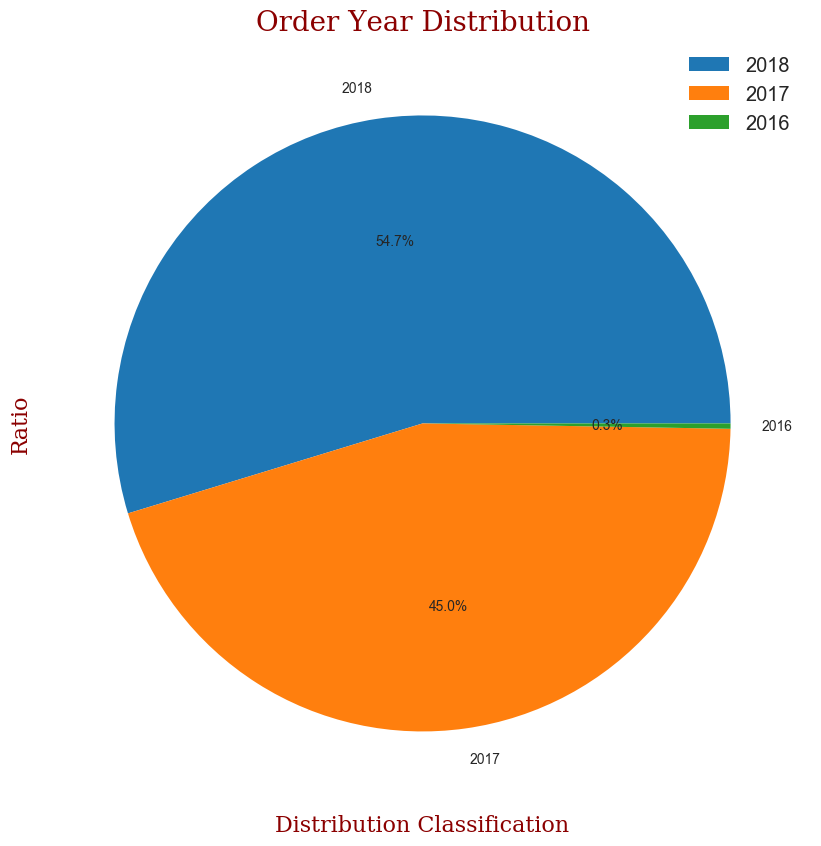

In [15]:
# Let's draw a pie chart to see the data distribution of years
od.order_purchase_timestamp.dt.year.value_counts().plot.pie(legend=True, autopct='%1.1f%%')
plt.title('Order Year Distribution', size=20, fontdict=font)
plt.xlabel('Distribution Classification', fontdict=font)
plt.ylabel('Ratio', fontdict=font)
plt.legend(loc='upper right', fontsize='x-large')
plt.gcf().set_size_inches(10, 10)

In [16]:
# date analysis on order delivered to customer timestamp
od['od_year'] = od['order_delivered_customer_date'].dt.year
od['od_month'] = od['order_delivered_customer_date'].dt.month
od['od_day'] = od['order_delivered_customer_date'].dt.day
od['od_week'] = od['order_delivered_customer_date'].dt.week
od['od_weekday_name'] = od['order_delivered_customer_date'].dt.weekday_name
od['od_weekday_number'] = od['order_delivered_customer_date'].dt.dayofweek

od.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approval_hours,seller_to_carrier_hours,carrier_to_customer_hours,early_delivery_hours,od_year,od_month,od_day,od_week,od_weekday_name,od_weekday_number
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0.178333,8.795833,1.503611,2.579722,2017,10,10,41,Tuesday,1
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,6.713889,11.109167,0.945833,8.537500,2018,8,7,32,Tuesday,1
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0.276111,4.910278,4.274722,5.891944,2018,8,17,33,Friday,4
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,0.298056,17.900000,10.811944,23.521667,2017,12,2,48,Saturday,5
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.030556,21.434722,22.507778,5.716111,2018,2,16,7,Friday,4


In [17]:
# discard 2016 data
od = od[(od.od_year==2017) | (od.od_year==2018)]

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text yticklabel objects>)

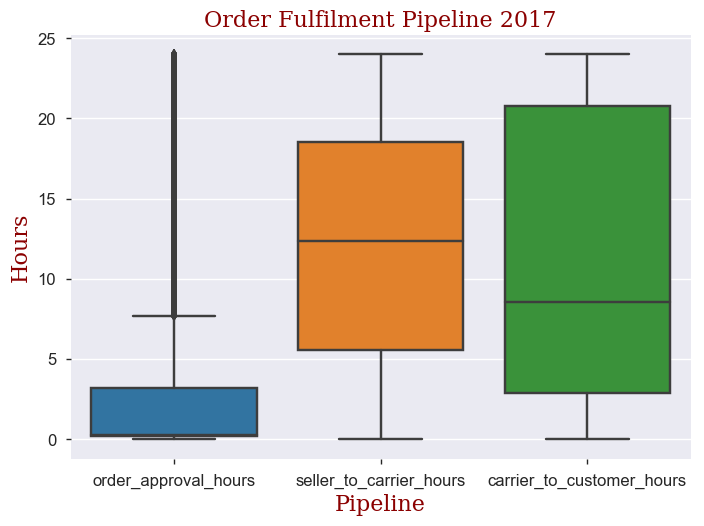

In [18]:
sns.boxplot(data=od[od.od_year == 2017].loc[:, ['order_approval_hours', 'seller_to_carrier_hours', 'carrier_to_customer_hours']])
plt.title('Order Fulfilment Pipeline 2017', fontdict=font)
plt.xlabel("Pipeline", fontdict=font)
plt.xticks(fontsize=12)
plt.ylabel('Hours', fontdict=font)
plt.yticks(fontsize=12)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text yticklabel objects>)

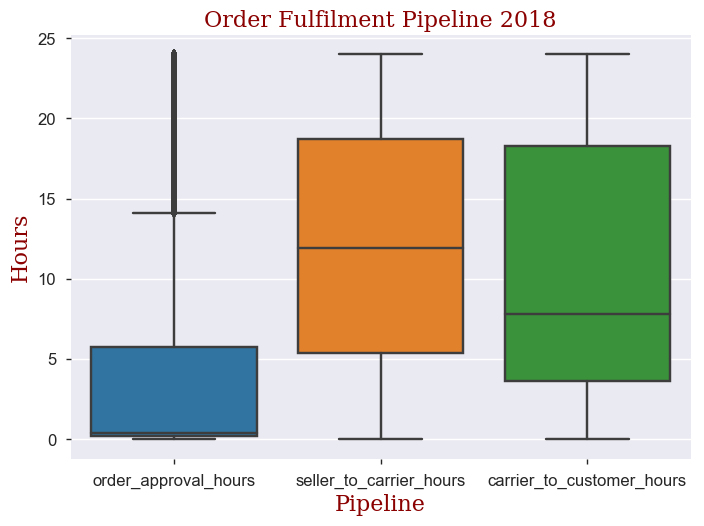

In [19]:
sns.boxplot(data=od[od.od_year == 2018].loc[:, ['order_approval_hours', 'seller_to_carrier_hours', 'carrier_to_customer_hours']])
plt.title('Order Fulfilment Pipeline 2018', fontdict=font)
plt.xlabel("Pipeline", fontdict=font)
plt.xticks(fontsize=12)
plt.ylabel('Hours', fontdict=font)
plt.yticks(fontsize=12)

#### INSIGHT
* order approval is very quick, mean is near 0, except a few outliers which
* Seller takes the most time in the lifecycle
* Variation in time taken by the carrier is higher

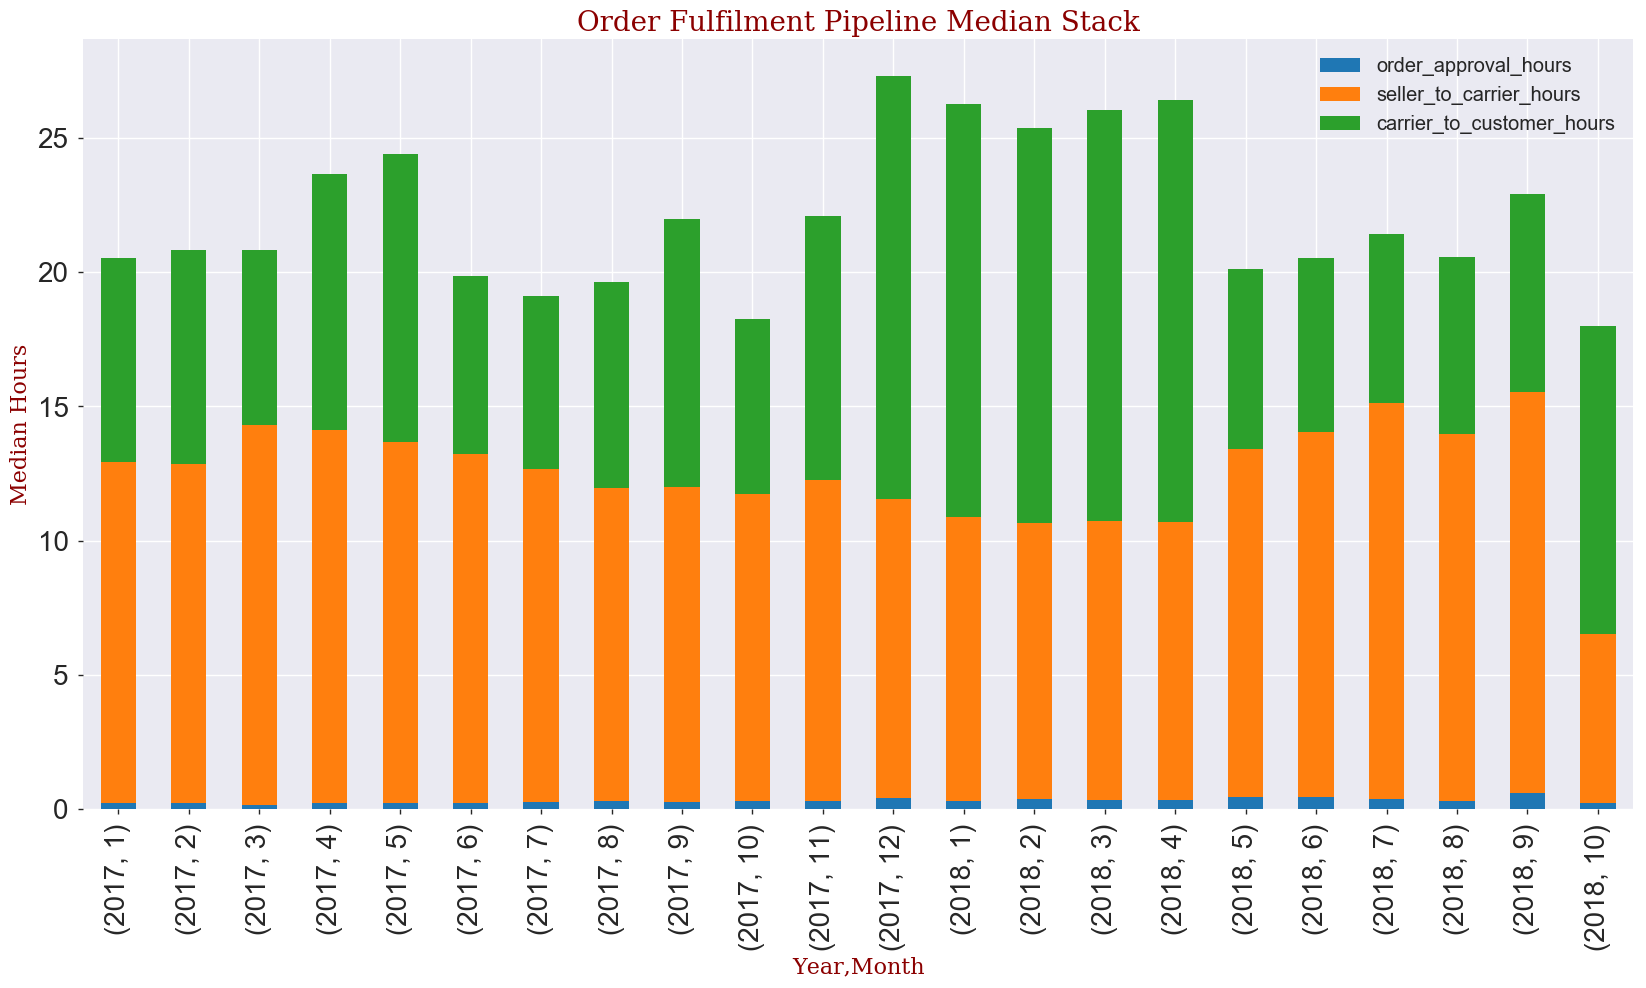

In [20]:
od[['order_approval_hours', 'seller_to_carrier_hours', 'carrier_to_customer_hours', 'od_year','od_month']].groupby(['od_year','od_month']).median().plot.bar(stacked=True)
plt.title('Order Fulfilment Pipeline Median Stack', size=20, fontdict=font)
plt.xlabel('Year,Month', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Median Hours', fontdict=font)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize='x-large')
plt.gcf().set_size_inches(20, 10)


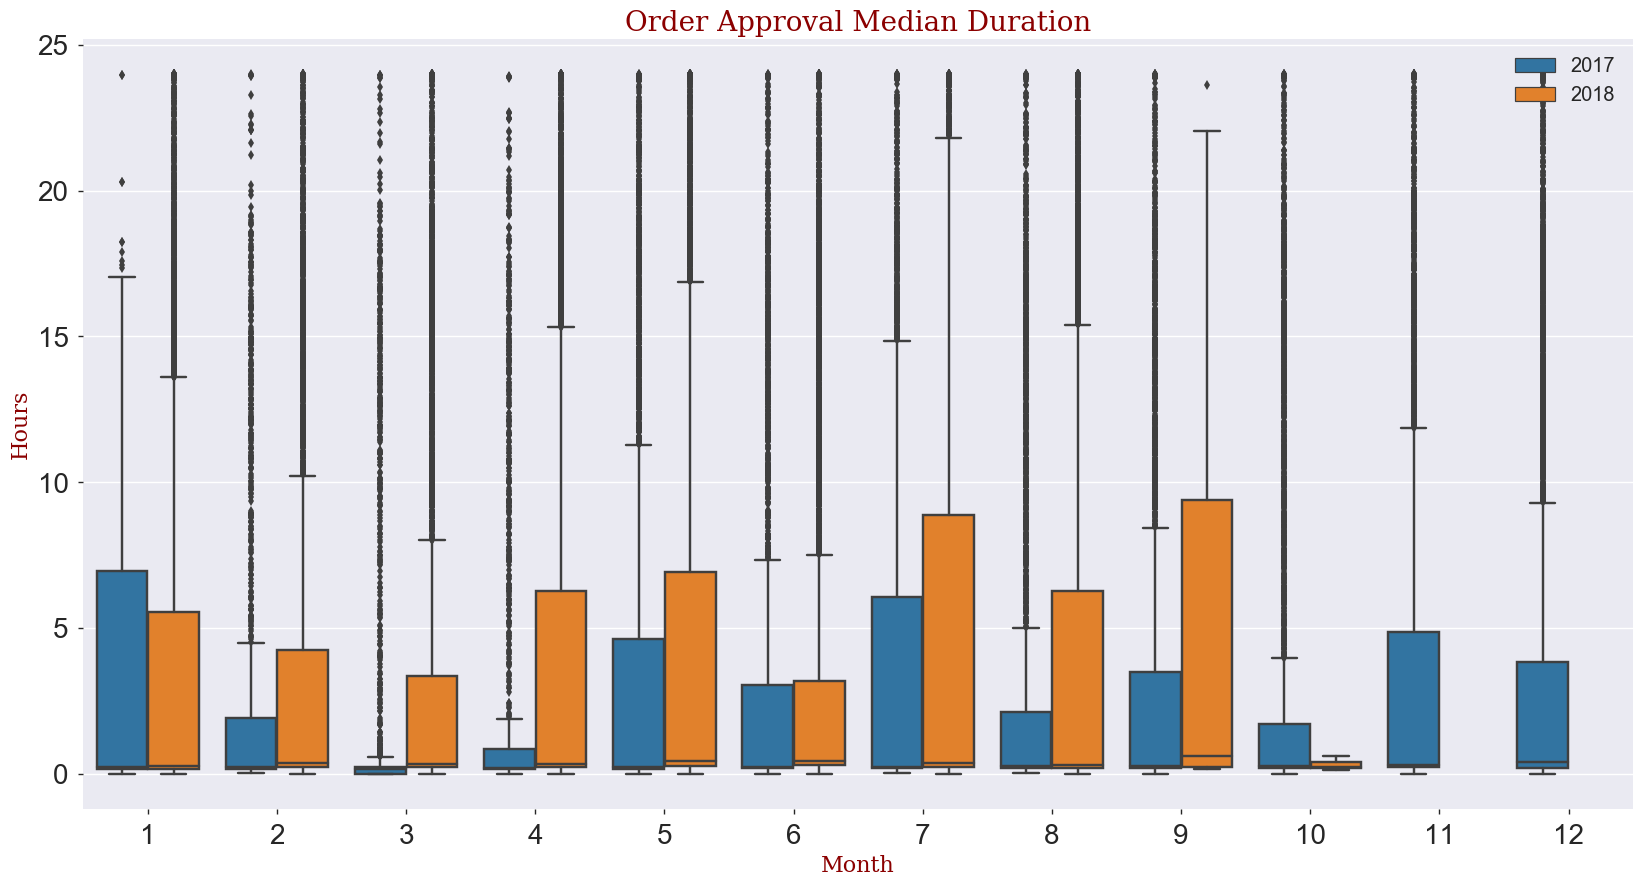

In [21]:
sns.boxplot(data=od[['order_approval_hours', 'od_month', 'od_year']], y='order_approval_hours', x='od_month', hue='od_year')
plt.title('Order Approval Median Duration', size=20, fontdict=font)
plt.xlabel('Month', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Hours', fontdict=font)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize='x-large')
plt.gcf().set_size_inches(20, 10)
#INSIGHT variation(or inconsistency) of approval hours has been more in 2018 than 2017

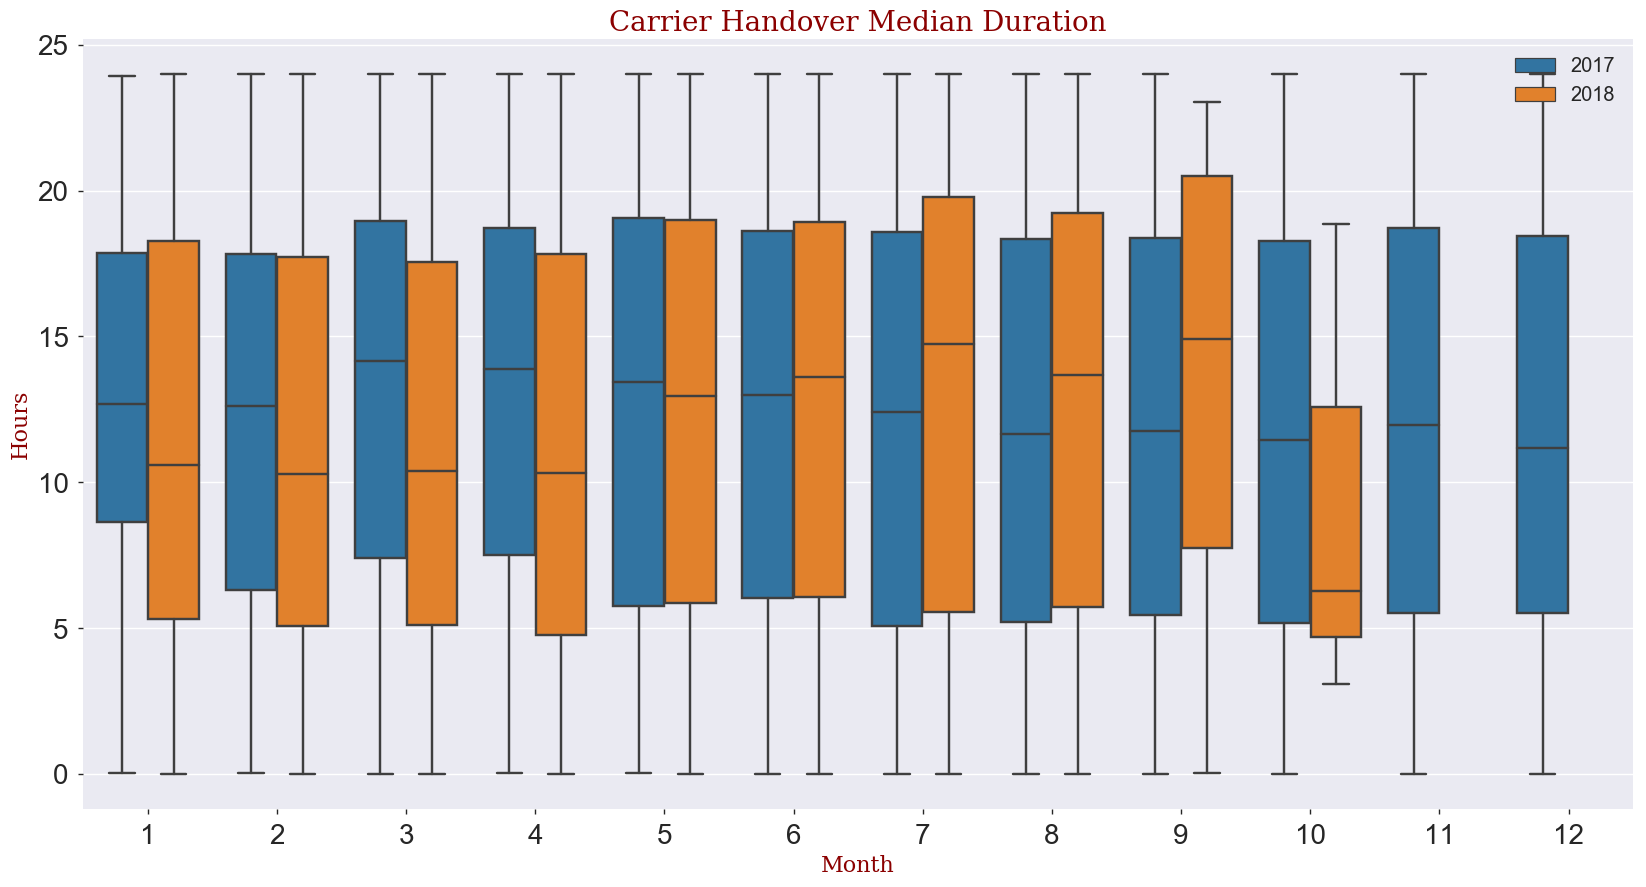

In [22]:
dt = od[['seller_to_carrier_hours', 'od_month', 'od_year']].sort_values(by='od_month')
sns.boxplot(data=dt, y='seller_to_carrier_hours', x='od_month', hue='od_year')
plt.title('Carrier Handover Median Duration', size=20, fontdict=font)
plt.xlabel('Month', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Hours', fontdict=font)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize='x-large')
plt.gcf().set_size_inches(20, 10)

# no visible inconsistency difference between 2017 and 2018 for seller to carrier hours

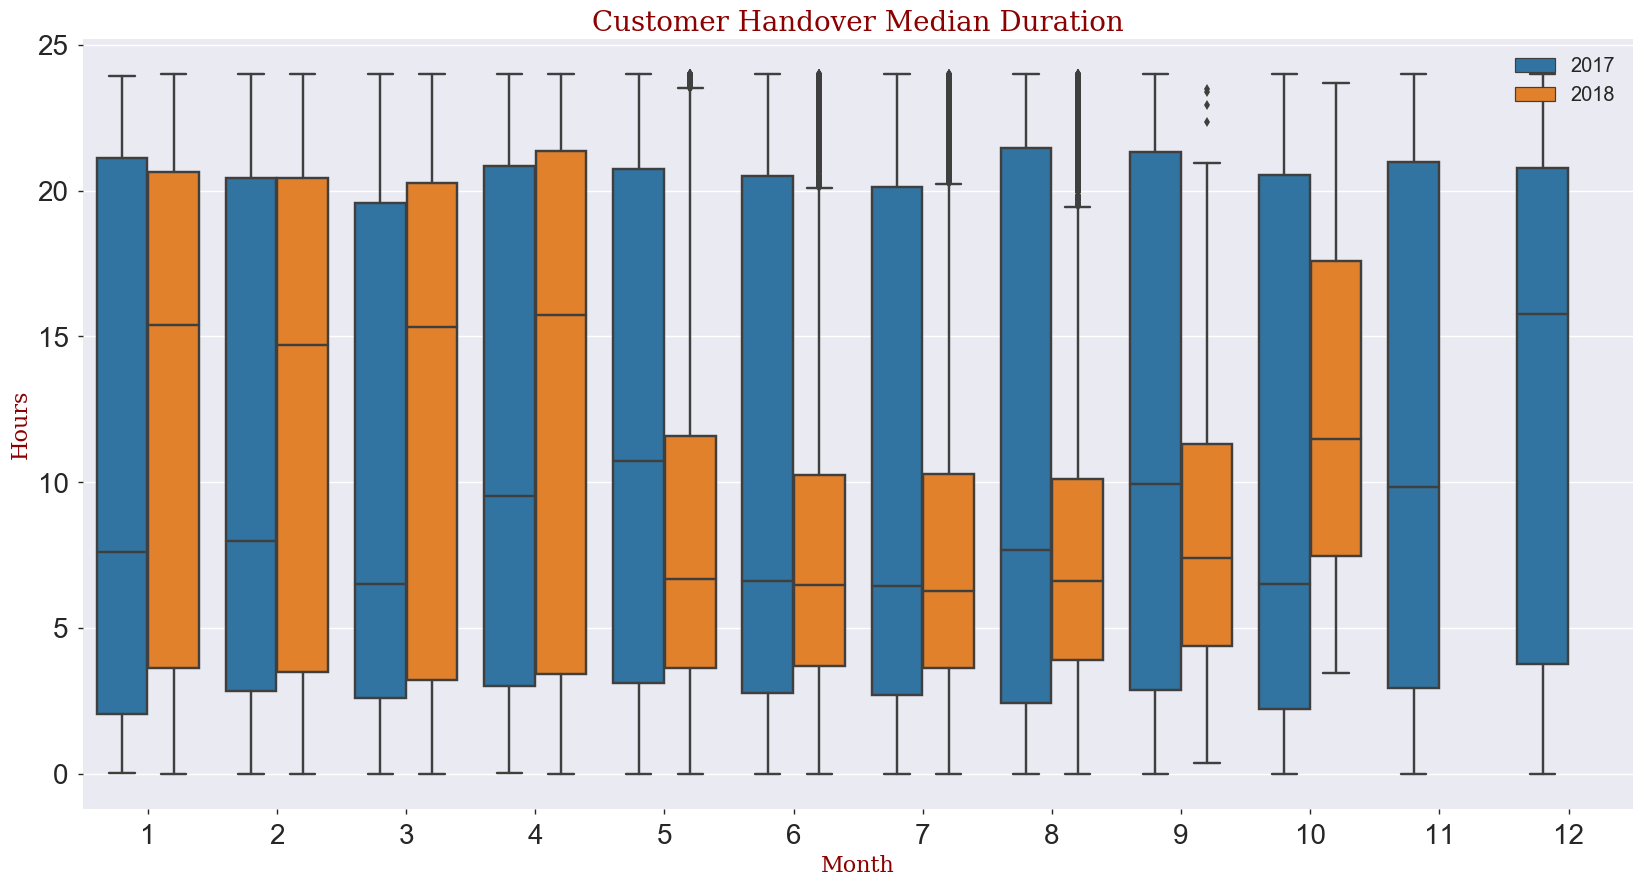

In [23]:
dt = od[['carrier_to_customer_hours', 'od_month', 'od_year']].sort_values(by='od_month')
sns.boxplot(data=dt, y='carrier_to_customer_hours', x='od_month', hue='od_year')
plt.title('Customer Handover Median Duration', size=20, fontdict=font)
plt.xlabel('Month', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Hours', fontdict=font)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize='x-large')
plt.gcf().set_size_inches(20, 10)

#INSIGHT: carrier to customer fulfillment variation is significantly low in 2018 may onwards as compared to 2017

### Sales Count Analysis

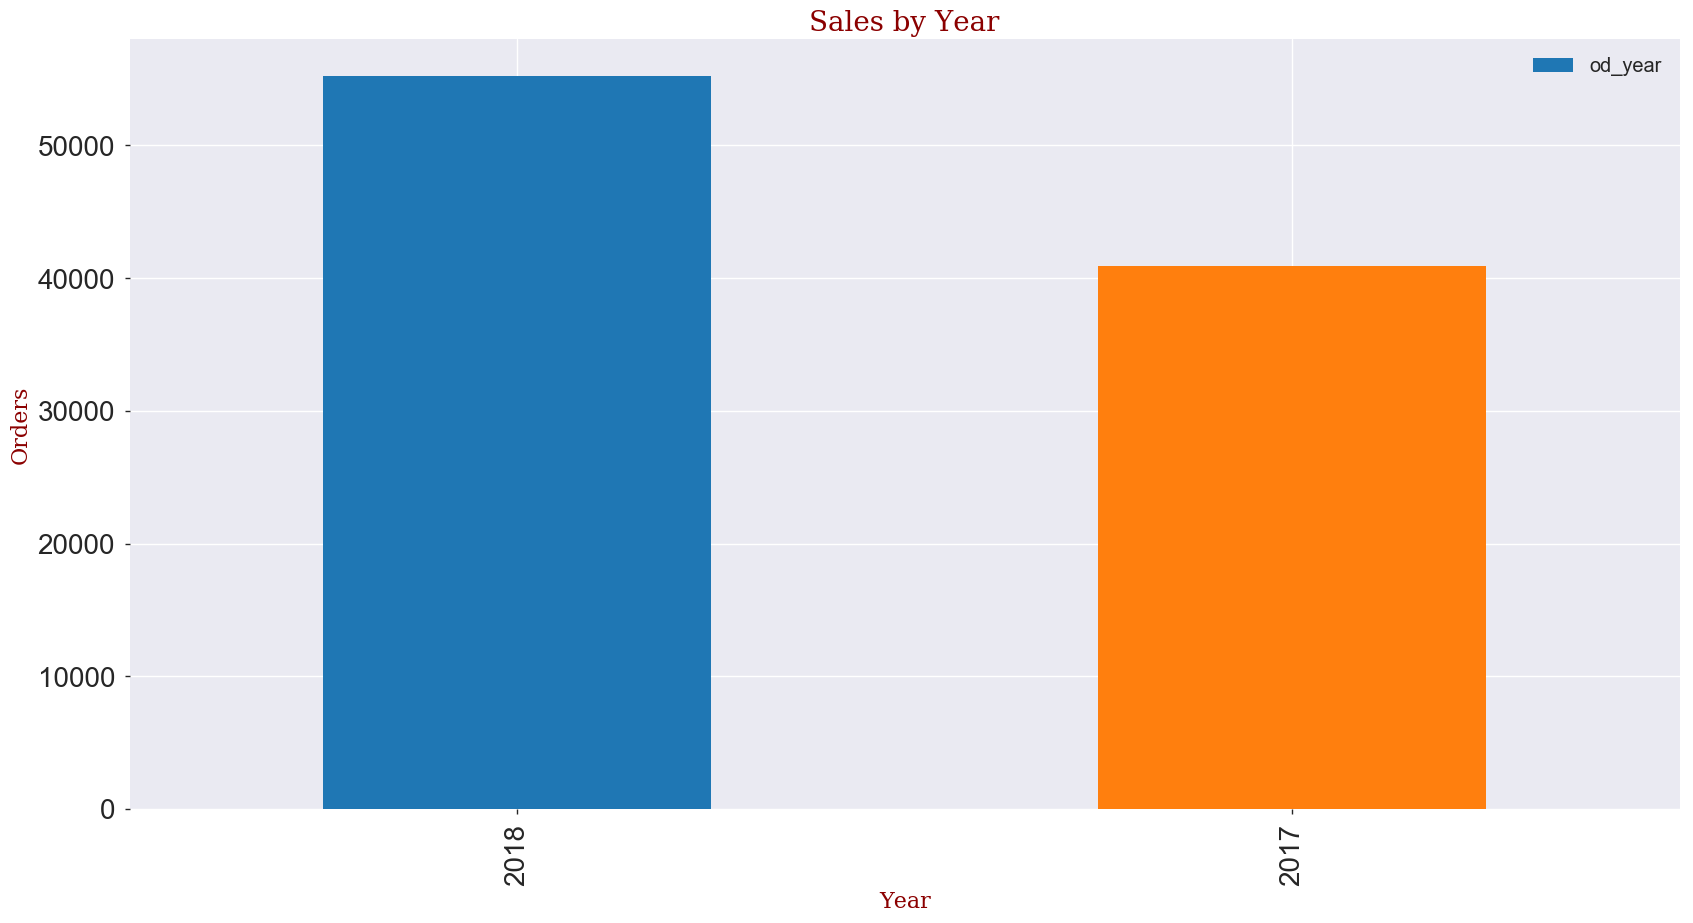

In [24]:
od['od_year'].value_counts().plot.bar()
plt.title('Sales by Year', size=20, fontdict=font)
plt.xlabel('Year', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Orders', fontdict=font)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize='x-large')
plt.gcf().set_size_inches(20, 10)

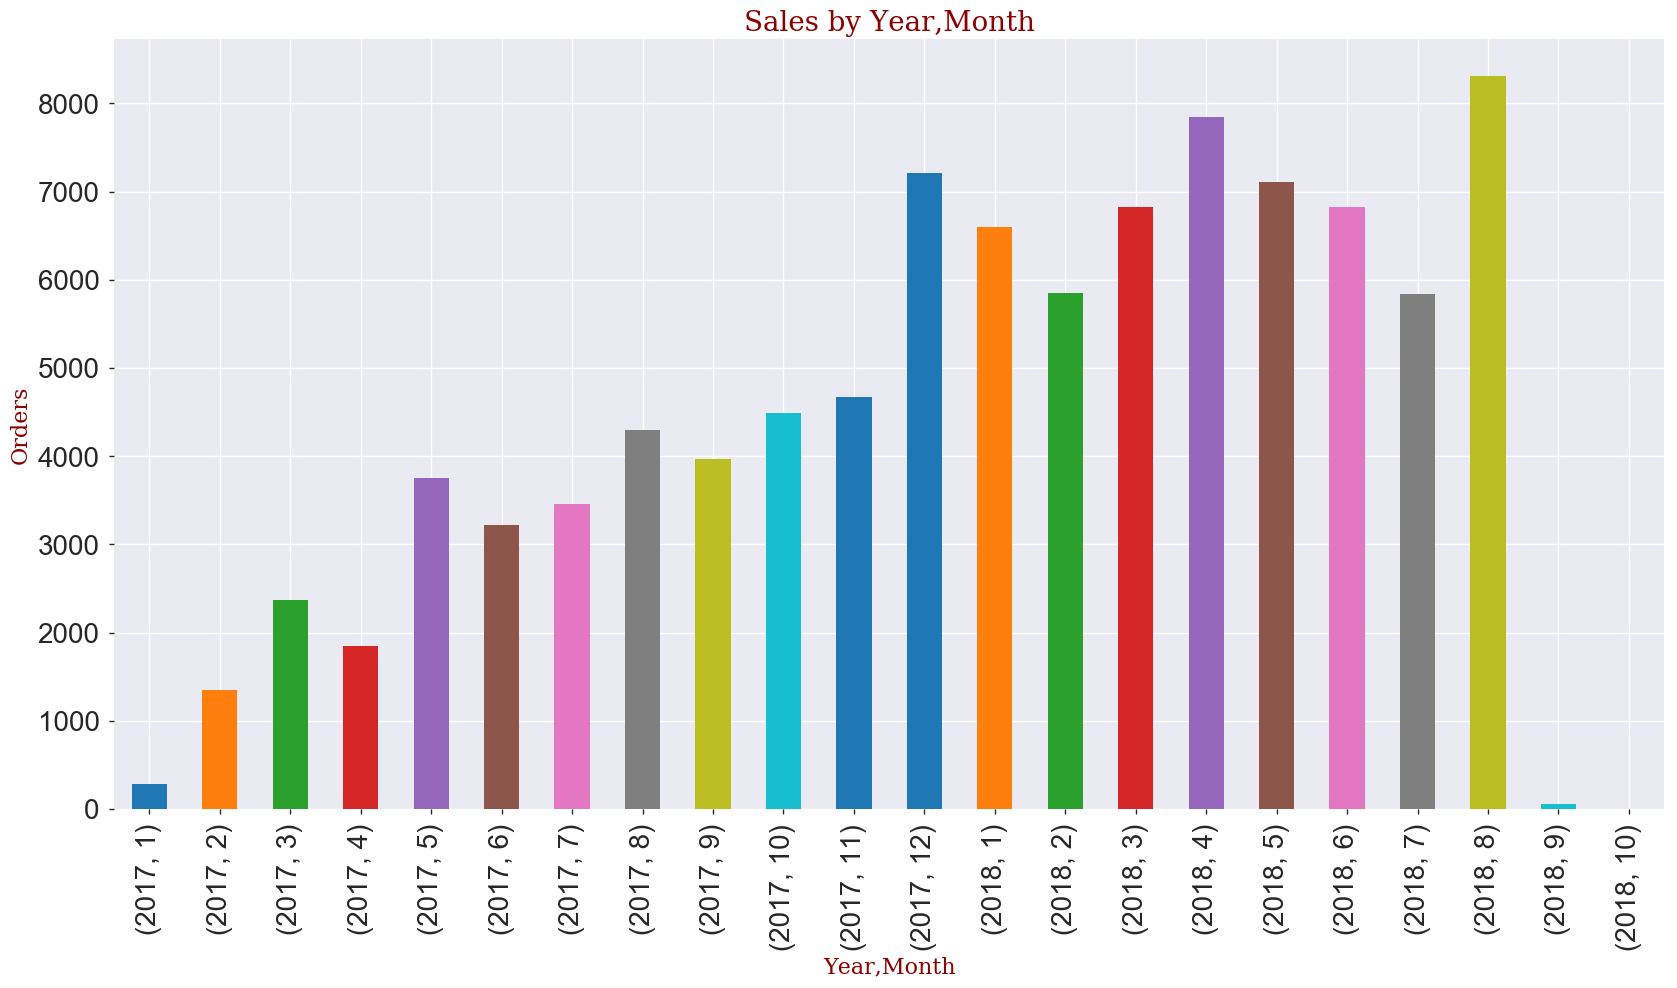

In [25]:
od.groupby(by=['od_year', 'od_month'])['order_approval_hours'].count().plot.bar()
plt.title('Sales by Year,Month', size=20, fontdict=font)
plt.xlabel('Year,Month', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Orders', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)
#INSIGHT: sales are increasing

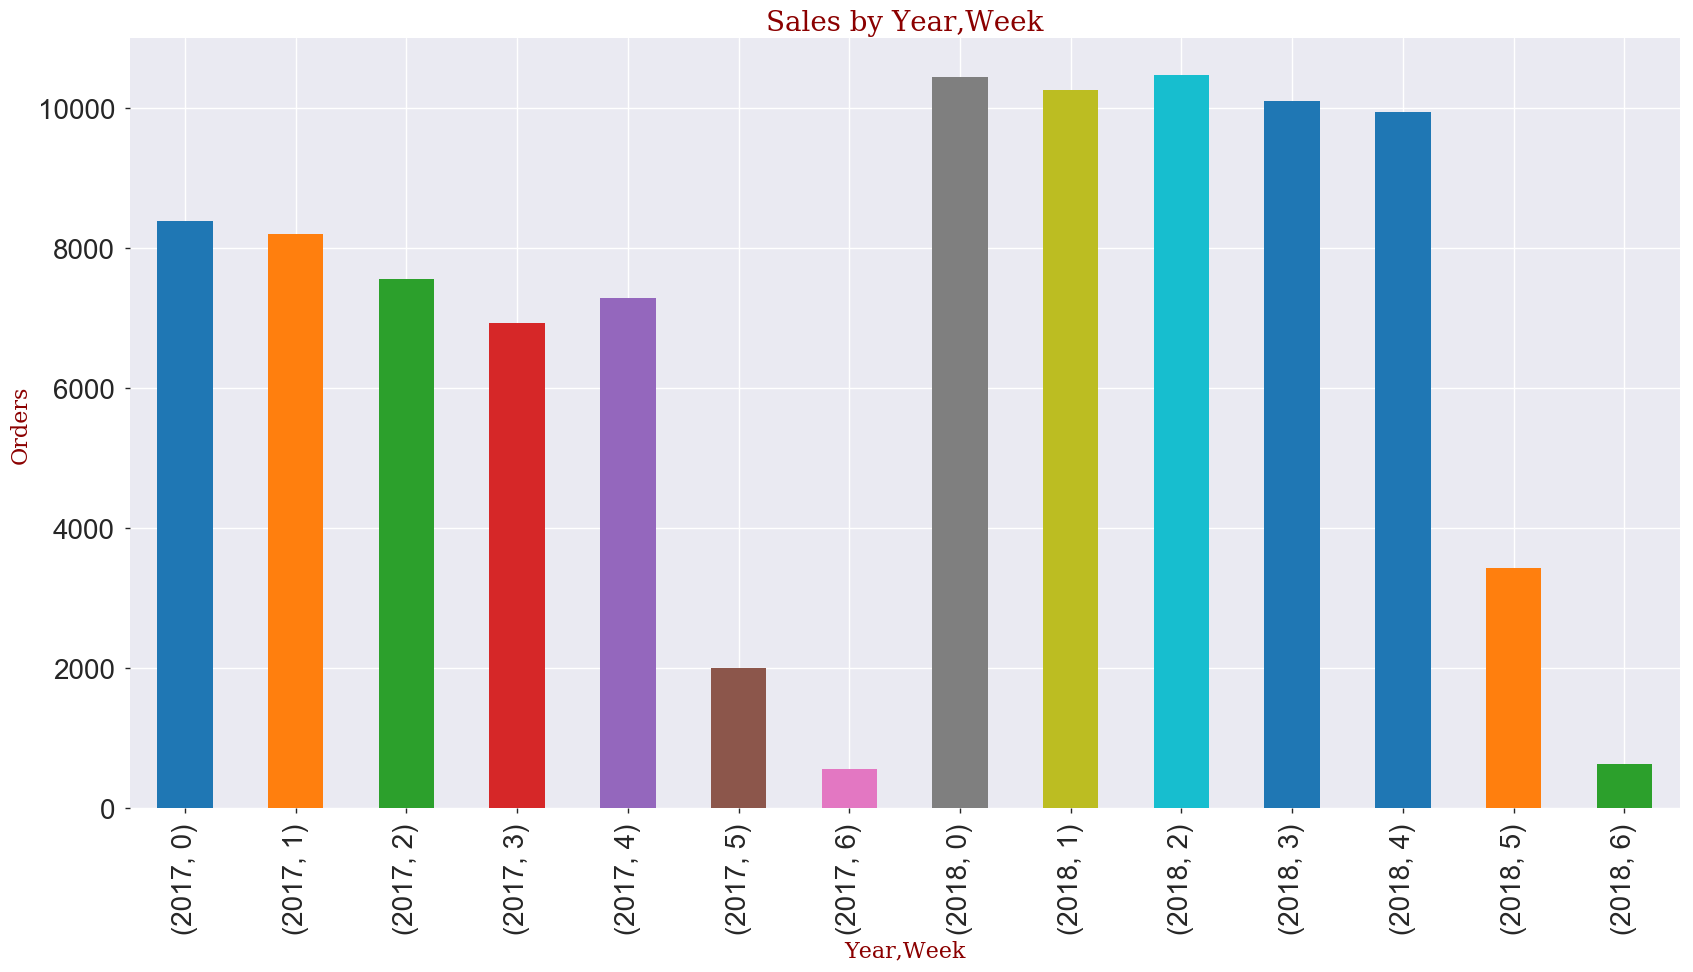

In [26]:
od.groupby(by=['od_year', 'od_weekday_number'])['order_approval_hours'].count().plot.bar()
plt.title('Sales by Year,Week', size=20, fontdict=font)
plt.xlabel('Year,Week', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Orders', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)
#INSIGHT: weekends have lesser purchases as compared to weekdays

### Intraday trends

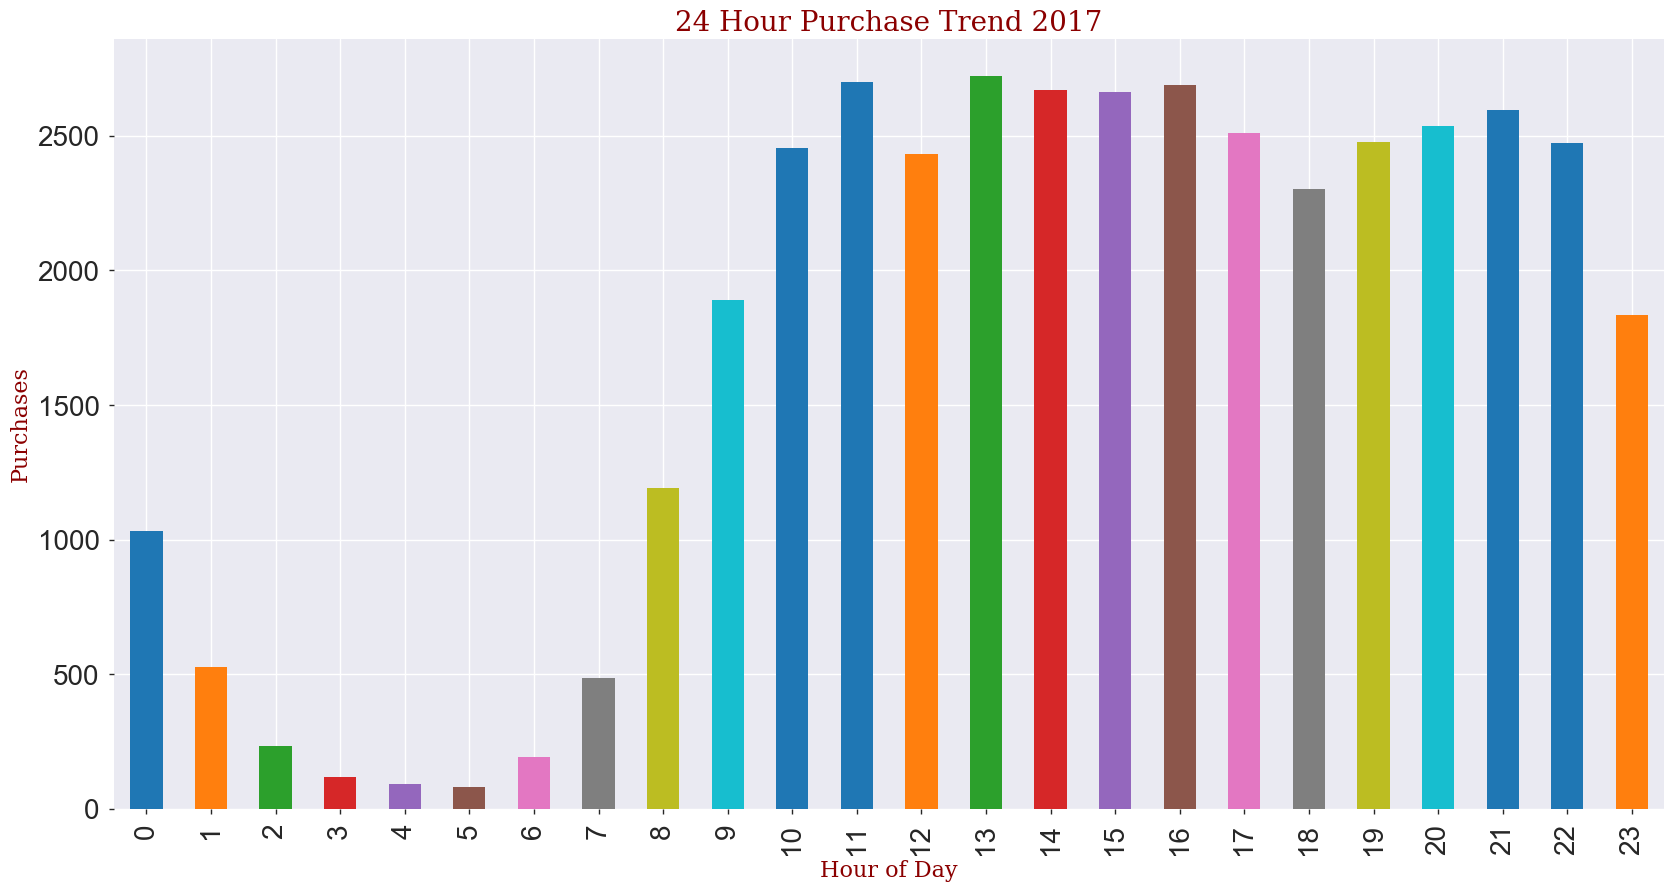

In [27]:
od[od.od_year == 2017]['order_purchase_timestamp'].dt.hour.value_counts().sort_index().plot.bar()
plt.title('24 Hour Purchase Trend 2017', size=20, fontdict=font)
plt.xlabel('Hour of Day', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Purchases', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)

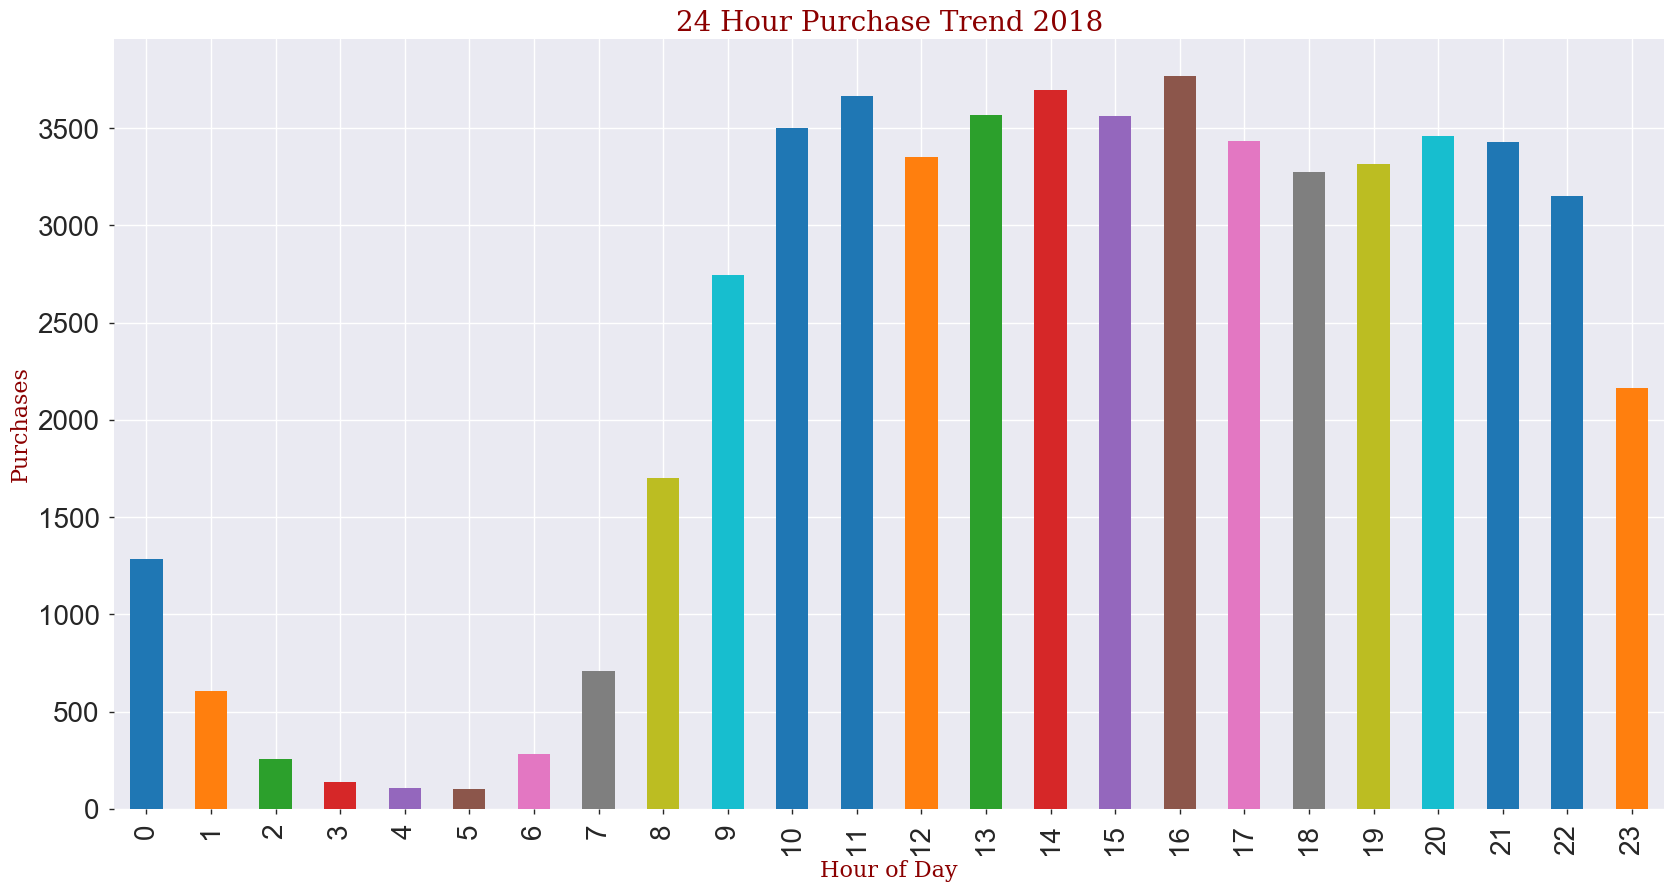

In [28]:
od[od.od_year == 2018]['order_purchase_timestamp'].dt.hour.value_counts().sort_index().plot.bar()
plt.title('24 Hour Purchase Trend 2018', size=20, fontdict=font)
plt.xlabel('Hour of Day', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Purchases', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)

In [29]:
#INSIGHT: limited purchases are made from midnight to early morning
#INSIGHT: almost consistent purchases from morning till 10pm

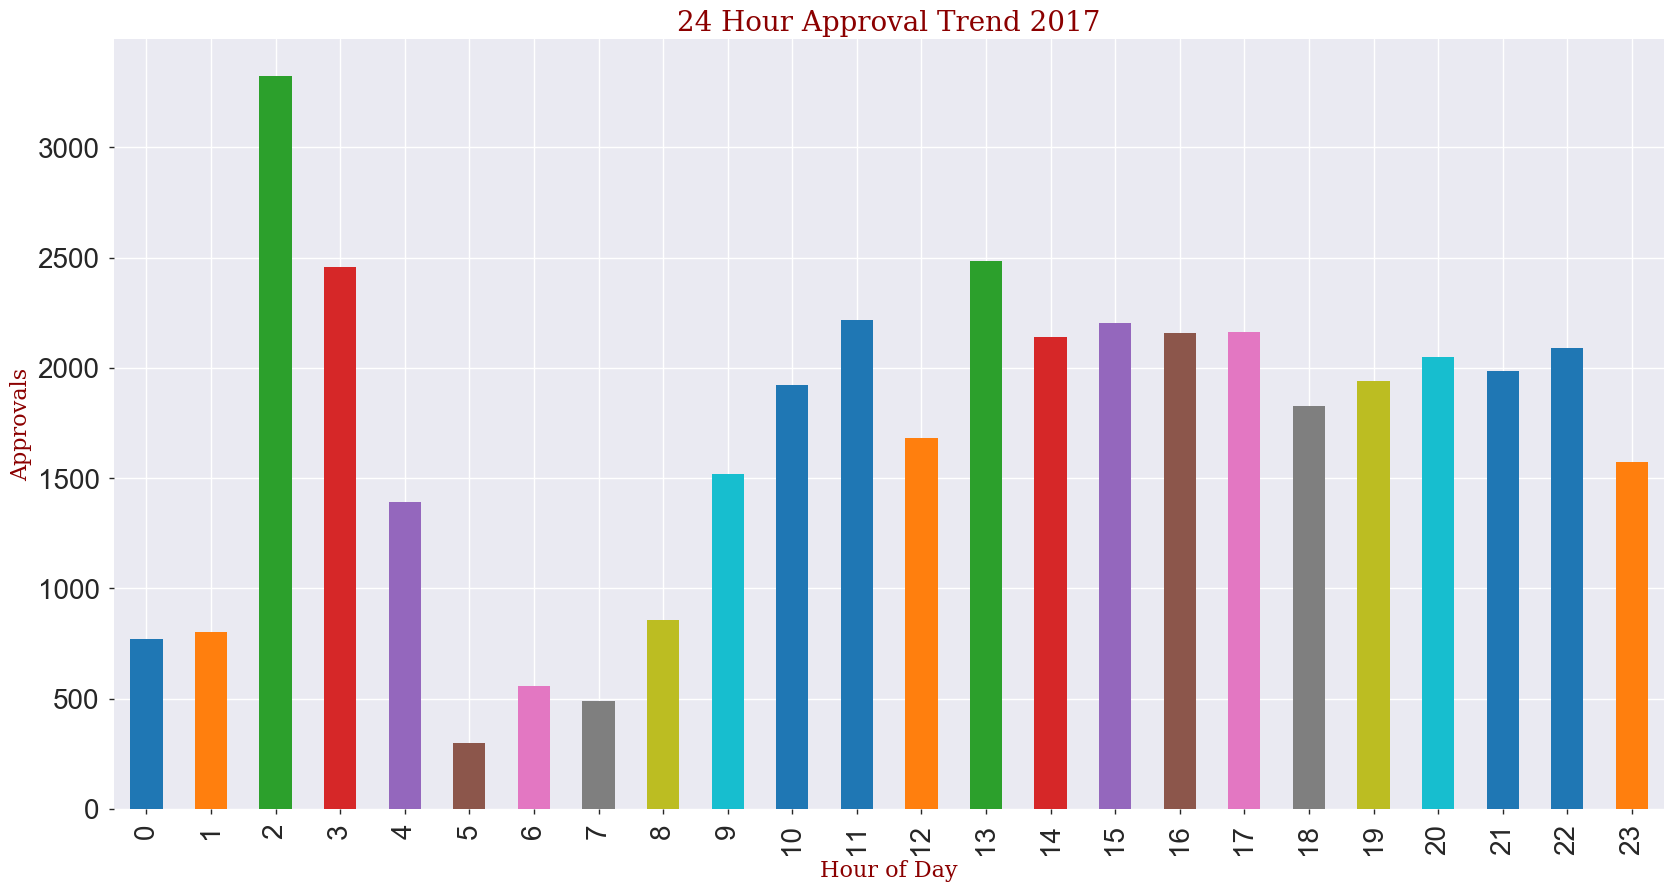

In [30]:
od[od.od_year == 2017]['order_approved_at'].dt.hour.value_counts().sort_index().plot.bar()
plt.title('24 Hour Approval Trend 2017', size=20, fontdict=font)
plt.xlabel('Hour of Day', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Approvals', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)

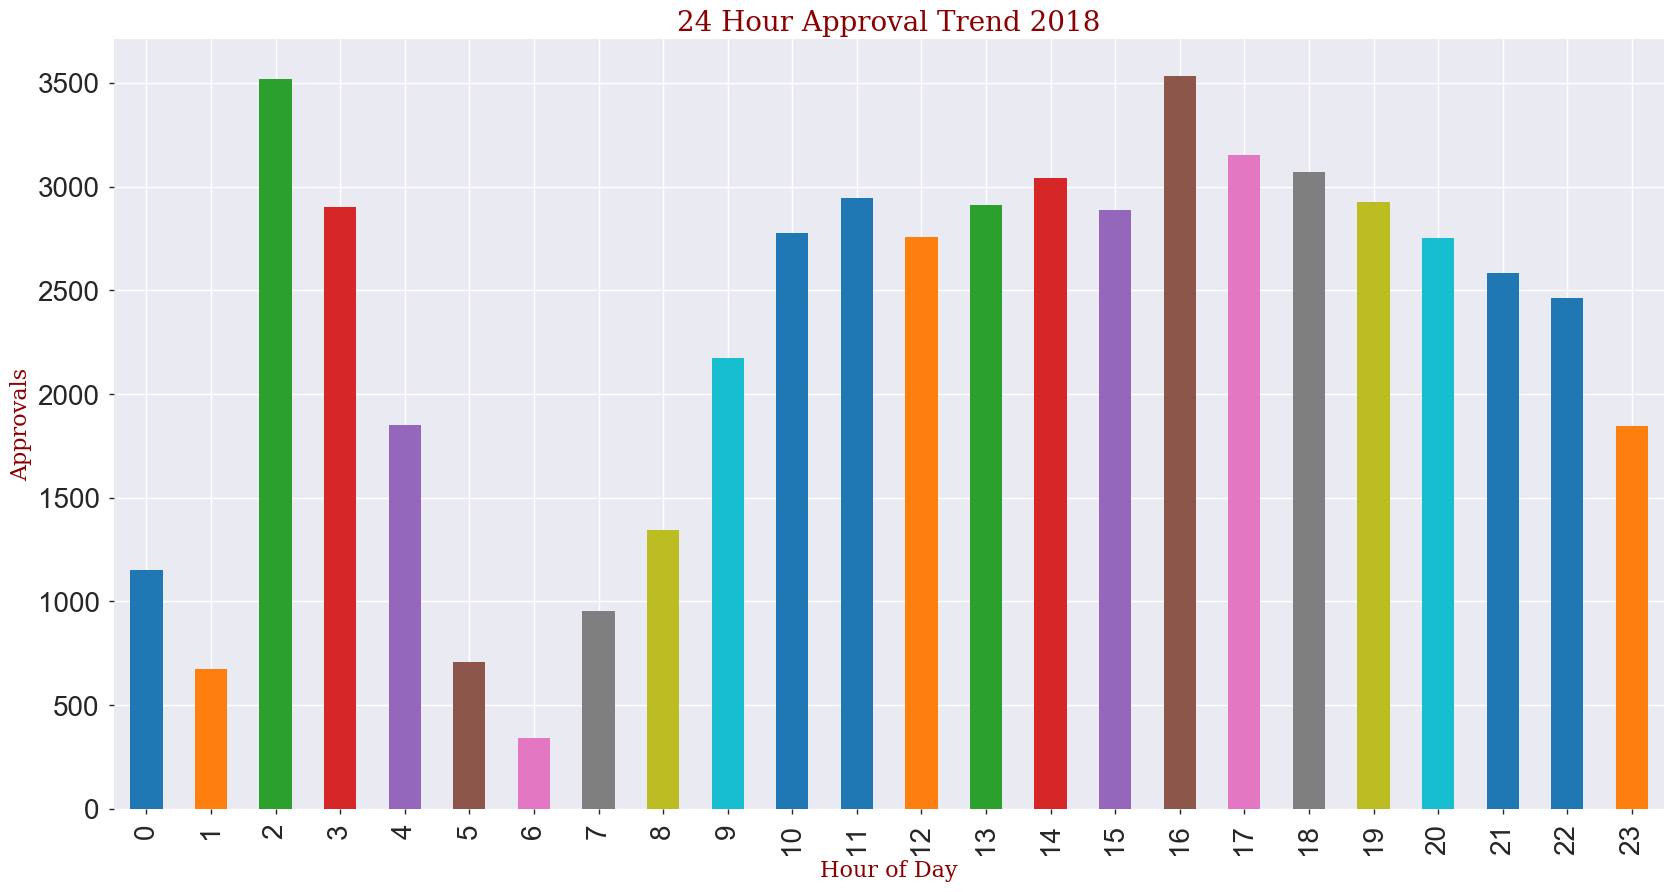

In [31]:
od[od.od_year == 2018]['order_approved_at'].dt.hour.value_counts().sort_index().plot.bar()
plt.title('24 Hour Approval Trend 2018', size=20, fontdict=font)
plt.xlabel('Hour of Day', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Approvals', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)

In [32]:
#INSIGHT: a lot of orders are approved at around 2 am

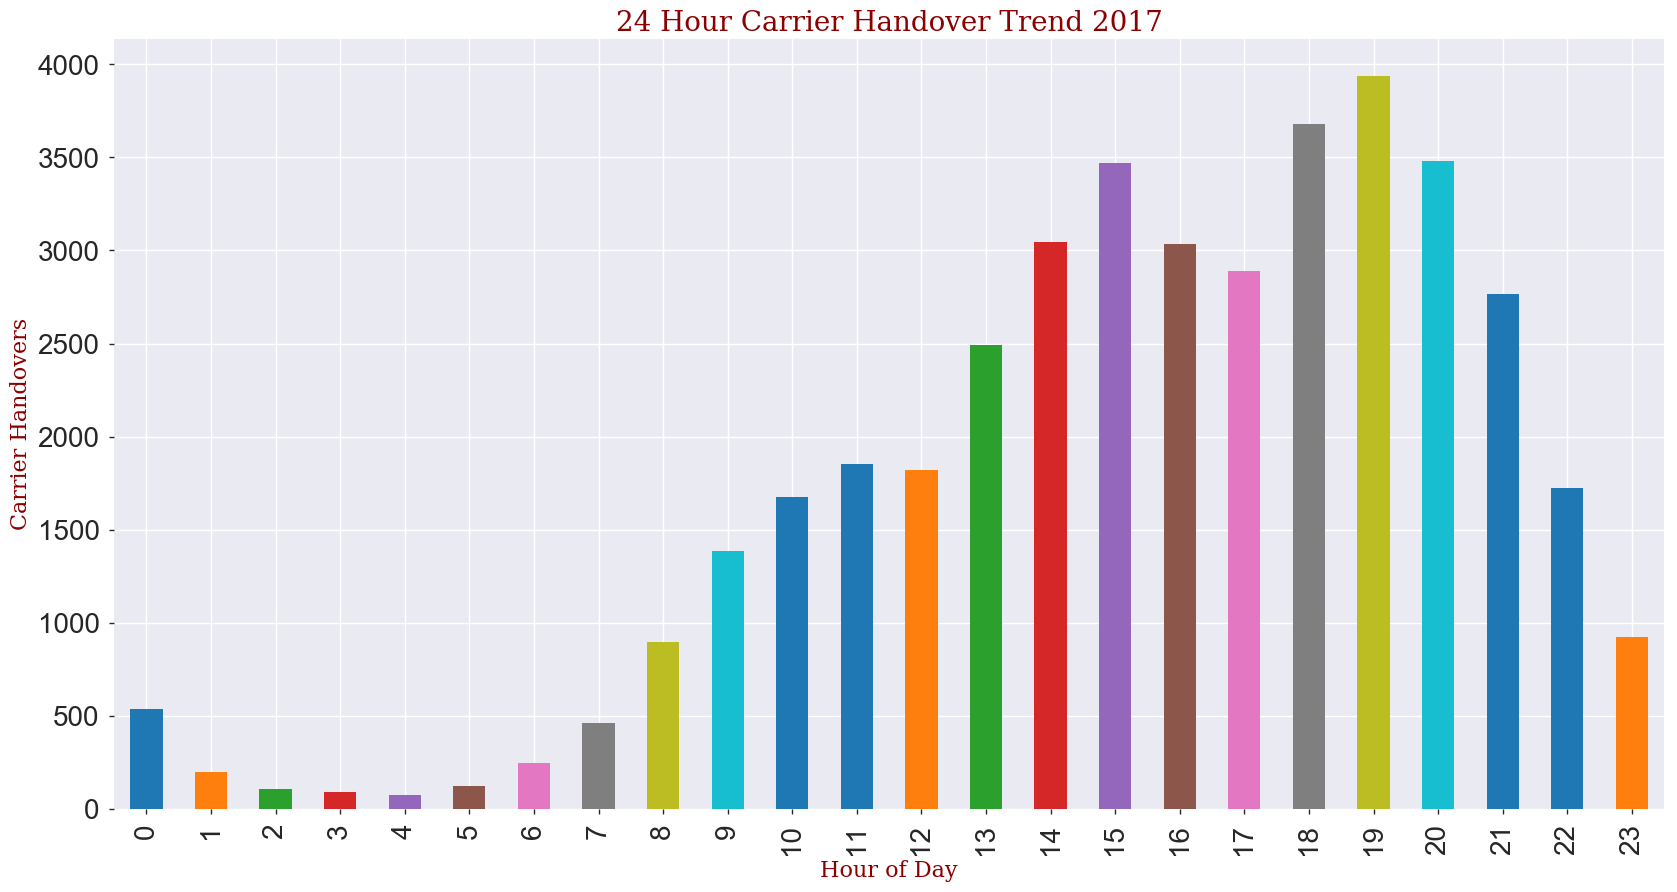

In [33]:
od[od.od_year == 2017]['order_delivered_carrier_date'].dt.hour.value_counts().sort_index().plot.bar()
plt.title('24 Hour Carrier Handover Trend 2017', size=20, fontdict=font)
plt.xlabel('Hour of Day', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Carrier Handovers', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)

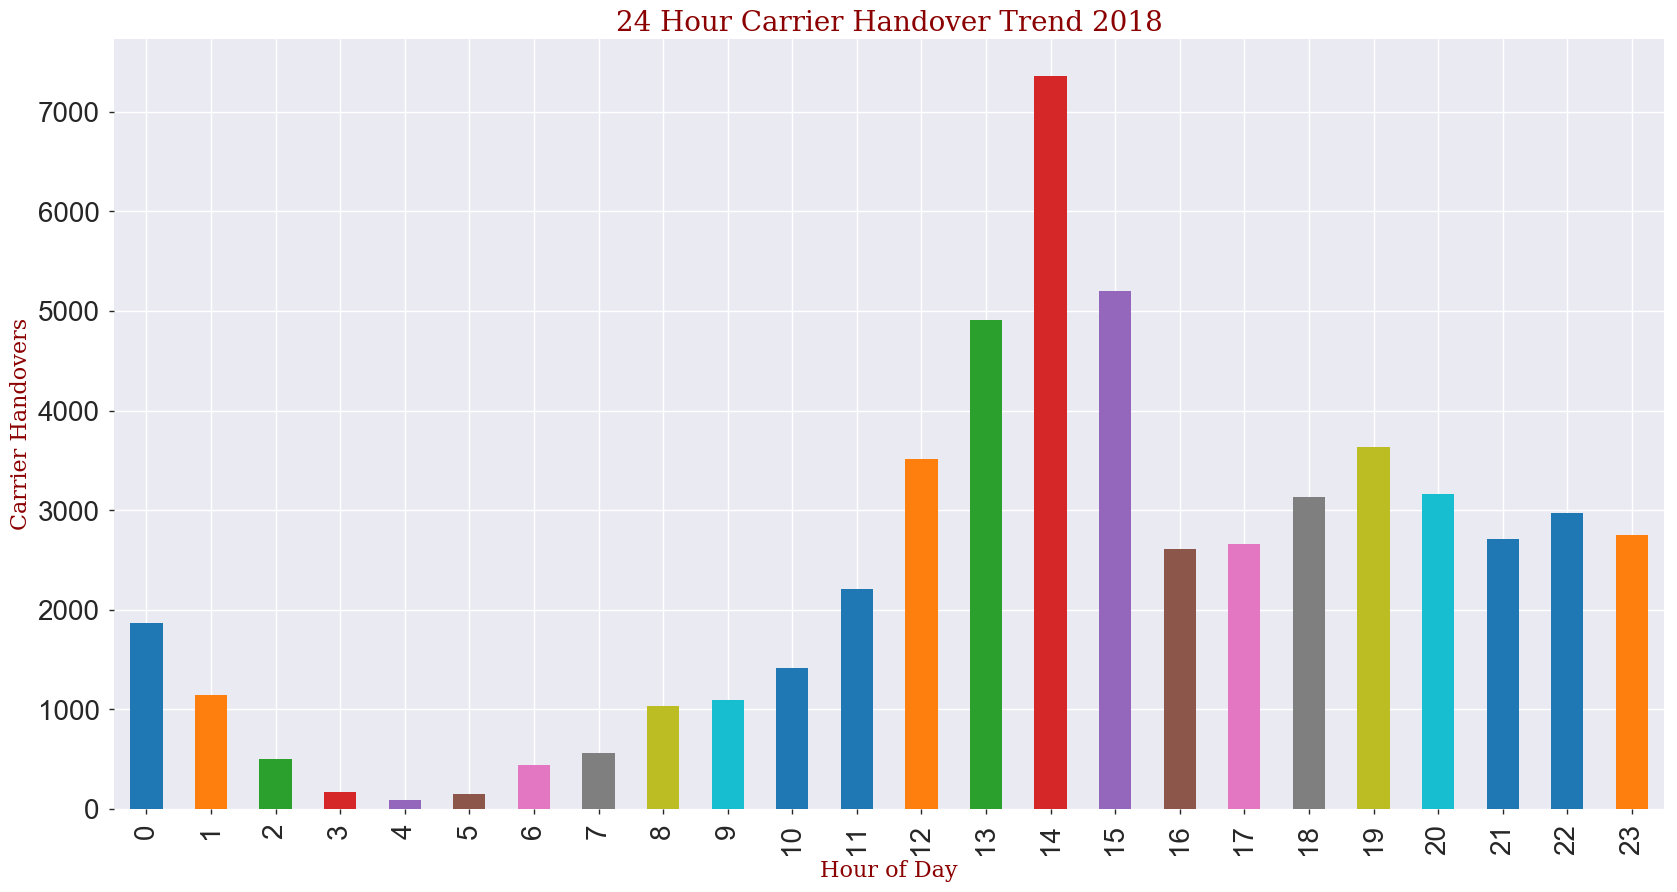

In [34]:
od[od.od_year == 2018]['order_delivered_carrier_date'].dt.hour.value_counts().sort_index().plot.bar()
plt.title('24 Hour Carrier Handover Trend 2018', size=20, fontdict=font)
plt.xlabel('Hour of Day', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Carrier Handovers', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)

In [35]:
#INSIGHT: usually orders are fulfilled to the carriers in day time
#INSIGHT: order fulfilment to carrier is increased in evenings in 2018

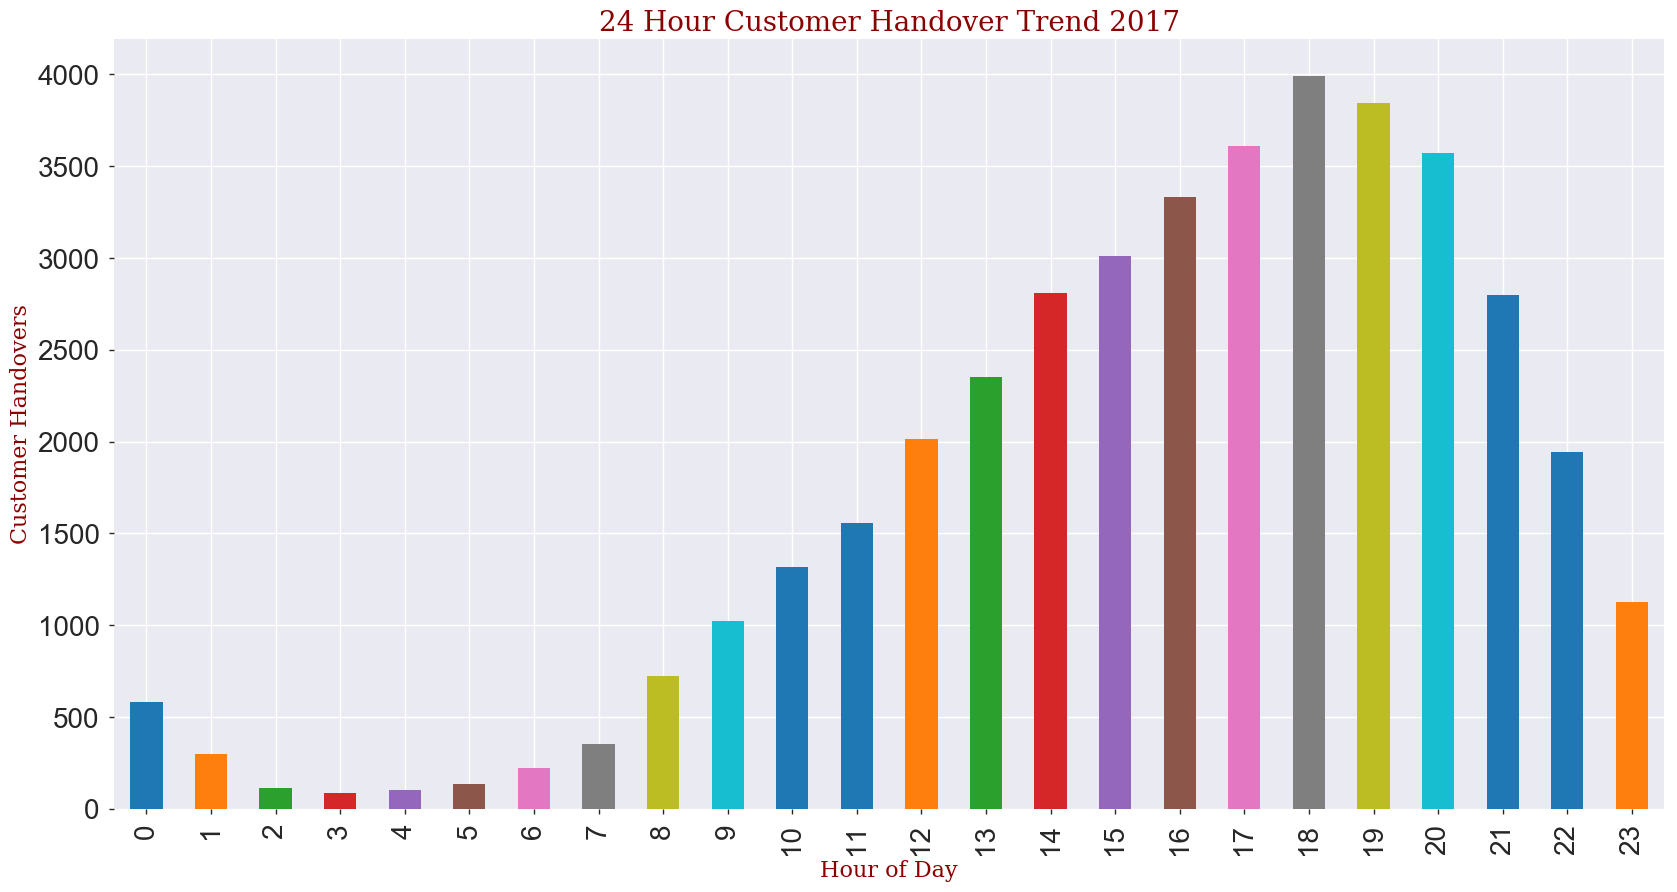

In [36]:
od[od.od_year == 2017]['order_delivered_customer_date'].dt.hour.value_counts().sort_index().plot.bar()
plt.title('24 Hour Customer Handover Trend 2017', size=20, fontdict=font)
plt.xlabel('Hour of Day', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Customer Handovers', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)

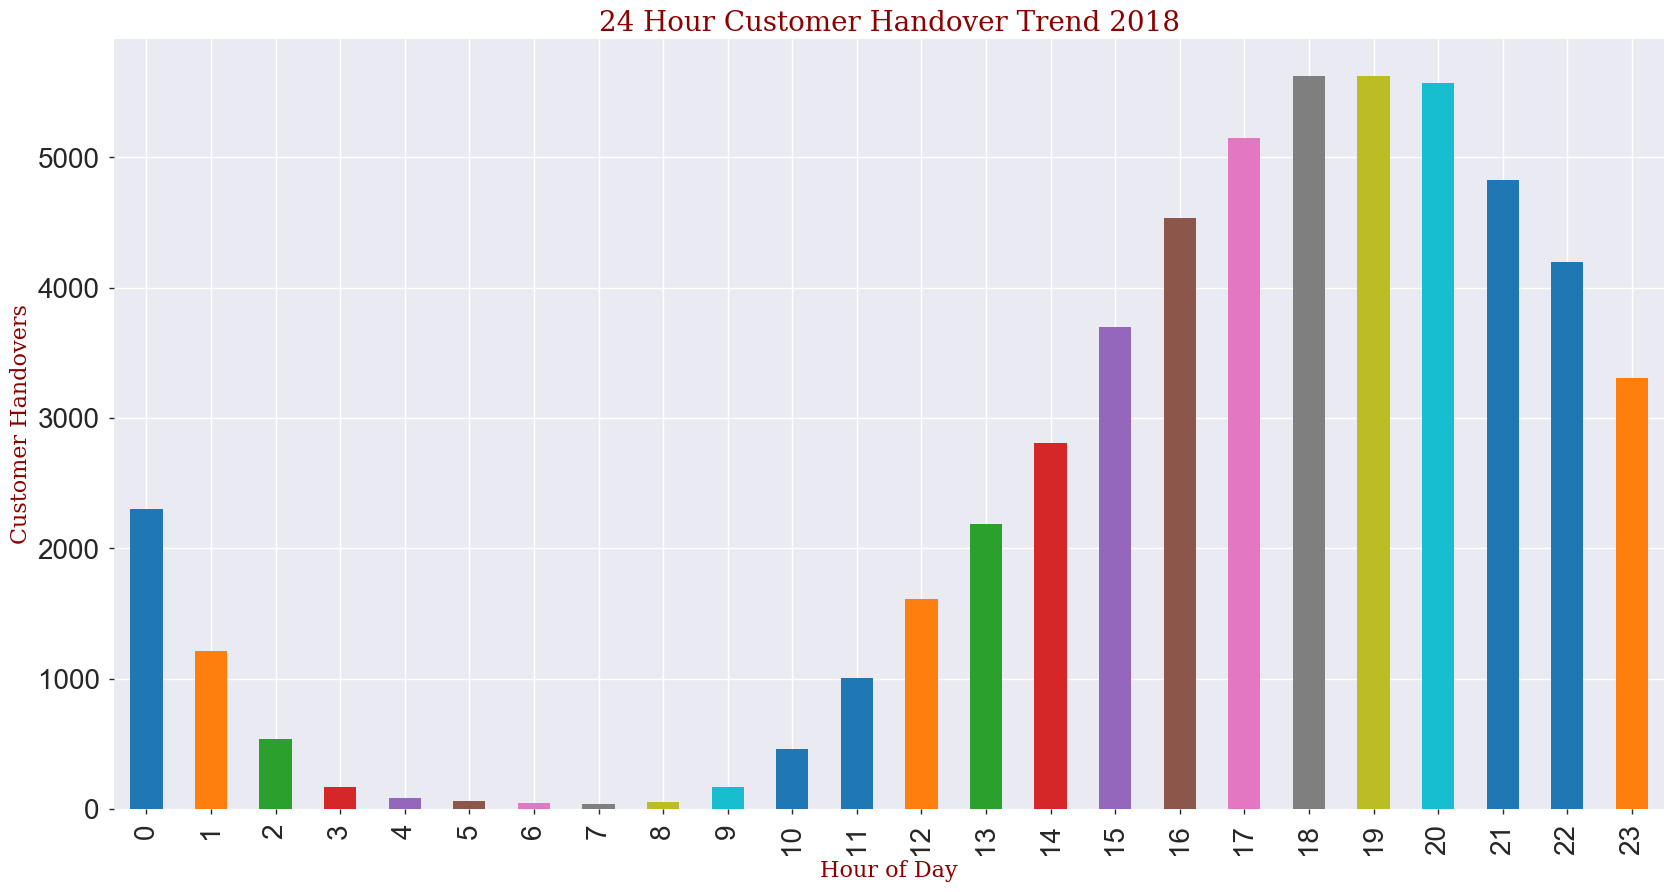

In [37]:
od[od.od_year == 2018]['order_delivered_customer_date'].dt.hour.value_counts().sort_index().plot.bar()
plt.title('24 Hour Customer Handover Trend 2018', size=20, fontdict=font)
plt.xlabel('Hour of Day', fontdict=font)
plt.xticks(fontsize=20)
plt.ylabel('Customer Handovers', fontdict=font)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20, 10)

In [38]:
#INSIGHT: the handover to customer doesn't happen in midnight to early morning

# Conclusions
* 97% of purchases were delivered to customer, less than 3% had issues at multiple levels; approval, delivery to carrier, delivery to customer
* there were a few orders which are in canceled state even after delivery to the customer
* Overall standard deviation at each step is very high
* Both seller and carrier exhibit a similar characteristic. Delivery throughput(number of orders deliveries) decreases with Delivery time at first, reaches a minima, then delivery throughput starts increasing with delivery time.
* Usually the item reaches customer 5-7 hours earlier than the promised estimated time of delivery
* Order approvals are quick
* Variation of seller and carrier delivery time is higher than approval time